In [20]:
import pandas as pd
import cobra
import cameo
from analysis_model import *
from bilansC import *
import escher
from cameo.flux_analysis.simulation import room, lmoma
from numpy import fabs
import seaborn as sns

In [16]:
show_escher = False
pd.options.display.max_colwidth = 1000
pd.options.display.max_rows = 1000
pd.options.display.column_space = 1000

In [17]:
wd = '/Users/aalarcon/Documents/Jupyter/3_Isopropanol/'
wd_figs = '/Users/aalarcon/Documents/Présentations/6_Réunion_dept/figures/'

## Define scenarios

In [18]:
#scen_pfba = ['WT', 'WT_o2lim200', 'WT_o2lim100', 'WT_o2lim50', 'WT_o2lim10', 'PKT', 'PKT_o2lim200', 'PKT_o2lim100', 'PKT_o2lim50', 'PKT_o2lim10']
#scen_pfba = ['WT_biomass', 'WT_max_isopropanol', 'PKT_biomass', 'PKT_max_isopropanol']
scen_pfba = ['PKT_o2lim_ac','PKT_o2lim_ac_ko', 'PKT_o2lim', 'PKT_o2lim_dels', 'PKT_o2lim_dels_PFL', 'PKT_o2lim_iprop50']


#scen_lmoma = ['WT_o2lim_dgdhA', 'PKT_o2lim_dgdhA']
scen_lmoma = []
ref_lmoma = {'WT_o2lim_dgdhA':'WT_o2lim', 'PKT_o2lim_dgdhA':'PKT_o2lim'}
scen = scen_pfba + scen_lmoma

## Run Simulation and save results

In [5]:
# Charge models
model = {s:cameo.load_model(wd+'input/models/model_'+s+'.json') for s in scen}
bmr = 'BIOMASS_Ec_iML1515_WT_75p37M'


In [9]:
# Modify parameters
for s in scen:
    model[s].solver = 'glpk'
#    model[s].reactions.EX_hxa_e.bounds = (0,0)
#    model[s].reactions.ACALD.bounds = (0,0)
    #model[s].reactions.EX_o2_e.bounds = (-10,0)
    #model[s].reactions.NADH16pp.bounds=(-1000,1000)

### pFBA

In [11]:
df_res = pd.DataFrame(index=scen_pfba, columns=['gr', 'ex_glc', 'acetone', 'iprop'])
react_data = dict()
for s in scen_pfba:
    try:
        res = cameo.pfba(model[s])
        react_data[s] = res.fluxes
        res.data_frame.to_csv(wd+'output/react_data/pFBA_'+s+'.csv')
        print('OK for', s+'\t')
        df_res.loc[s] = [format(res.data_frame.loc[bmr, 'flux'],'.2f'), 
              format(res.data_frame.loc['EX_glc__D_e', 'flux'],'.0f'),
              format(res.data_frame.loc['EX_acetone_e', 'flux'],'.0f'),
              format(res.data_frame.loc['EX_2ppoh_e', 'flux'],'.0f')]
        
    except:
        print('*** Error for strain:',s)
df_res

OK for PKT_o2lim_ac	
OK for PKT_o2lim_ac_ko	
OK for PKT_o2lim	
OK for PKT_o2lim_dels	
OK for PKT_o2lim_dels_PFL	
OK for PKT_o2lim_iprop50	


,gr,ex_glc,acetone,iprop
PKT_o2lim_ac,2.50,-100,0,0
PKT_o2lim_ac_ko,1.05,-100,0,0
PKT_o2lim,1.65,-100,0,103
PKT_o2lim_dels,1.65,-100,0,112
PKT_o2lim_dels_PFL,1.62,-100,0,112
PKT_o2lim_iprop50,1.62,-100,0,119


## Exchanges

In [12]:
bilan_exchanges(react_data, model['PKT_o2lim_dels_PFL'], threshold=10, scen=scen, mets_c=False, name_formula=False)

,PKT_o2lim_ac,PKT_o2lim_ac_ko,PKT_o2lim,PKT_o2lim_dels,PKT_o2lim_dels_PFL,PKT_o2lim_iprop50
gr,2.5,1.05,1.65,1.65,1.62,1.62
h2o_e,43,156,108,98,115,108
h_e,286,78,136,155,124,138
nh4_e,-26,-11,-17,-17,-17,-17
o2_e,-10,-10,-10,-10,-10,-10


## Carbon Balance

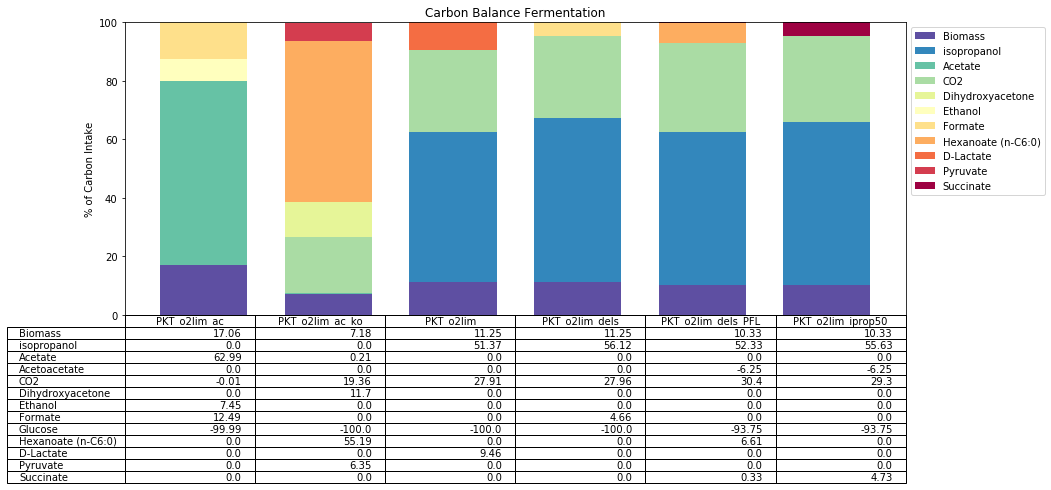

In [21]:
fig = bilanC(data_model=react_data , scen_model=scen, model=model[scen[-1]], threshold=10, figsize=(14,7))
#fig.savefig(wd_figs+'bilanC_o2lim50_dels.png', bbox_inches='tight')

## Flux Variability Analysis

In [22]:
reacts_fva = 'EX_2ppoh_e EX_acetone_e EX_etoh_e EX_lac__D_e EX_succ_e GLUDy'.split()

hier_idx = pd.MultiIndex.from_product([reacts_fva, ['max', 'min']], names=['reacts', 'fva'])
res_fva = pd.DataFrame(index=scen, columns=hier_idx)

for s in scen_pfba:
    res = cameo.flux_variability_analysis(model[s], reactions=reacts_fva, fraction_of_optimum=1)
    for r in reacts_fva:
        res_fva.loc[s, r]['min'] = format(res.data_frame.loc[r, 'lower_bound'], '.1f')
        res_fva.loc[s, r]['max'] = format(res.data_frame.loc[r, 'upper_bound'], '.1f')
res_fva

reacts             EX_2ppoh_e        EX_acetone_e       EX_etoh_e        \
fva                       max    min          max   min       max   min   
PKT_o2lim_ac             -0.0   -0.0         -0.0  -0.0      22.3  22.3   
PKT_o2lim_ac_ko           0.0    0.0          0.0   0.0       0.0   0.0   
PKT_o2lim               122.2  102.7         -0.0  -0.0      18.9   0.0   
PKT_o2lim_dels          122.2  112.2          0.0   0.0       0.0   0.0   
PKT_o2lim_dels_PFL      111.6  111.1          0.0   0.0       0.0   0.0   
PKT_o2lim_iprop50       118.7  111.1          0.0   0.0       0.0   0.0   

reacts             EX_lac__D_e       EX_succ_e        GLUDy         
fva                        max   min       max   min    max    min  
PKT_o2lim_ac              -0.0  -0.0      -0.0  -0.0  -20.8  -20.8  
PKT_o2lim_ac_ko            0.0   0.0       0.0   0.0   -8.8  -54.2  
PKT_o2lim                 18.9   0.0      -0.0  -0.0  -13.7  -13.8  
PKT_o2lim_dels             0.0   0.0       0.0   0.0  -13.7  -13.8  
PKT_o2lim_dels_PFL         0.0   0.0       0.5   0.0  -13.5  -13.5  
PKT_o2lim_iprop50          0.0   0.0       7.6   0.0  -13.5  -13.5

## Metabolite Balance

In [103]:
met = '2dmmql8_c'
bilan_metabolite(met, react_data, model[scen[-1]], threshold=0, scen=scen[-1:],
                 show_name=False, show_reaction=True, show_genes=False)

,PKT_o2lim_iprop50,reaction
NADH18pp,0,2dmmq8_c + 4.0 h_c + nadh_c --> 2dmmql8_c + 3.0 h_p + nad_c
TMAOR2pp,-0,2dmmql8_c + h_p + tmao_p --> 2dmmq8_c + h2o_p + tma_p
G3PD7,0,2dmmq8_c + glyc3p_c --> 2dmmql8_c + dhap_c
DHNAOT4,0,dhna_c + h_c + octdp_c --> 2dmmql8_c + co2_c + ppi_c
GLYCTO4,0,2dmmq8_c + glyclt_c --> 2dmmql8_c + glx_c
BIOMASS_Ec_iML1515_WT_75p37M,-0,
FRD3,-0,2dmmql8_c + fum_c --> 2dmmq8_c + succ_c
HYD3pp,0,2dmmq8_c + h2_c + 2.0 h_c --> 2dmmql8_c + 2.0 h_p
NADH9,0,2dmmq8_c + h_c + nadh_c --> 2dmmql8_c + nad_c
DMSOR2,-0,2dmmql8_c + dmso_c --> 2dmmq8_c + dms_c + h2o_c


In [90]:
model[scen[-1]].reactions.MDH

Reaction identifier,MDH
Name,Malate dehydrogenase
Memory address,0x015567add8
Stoichiometry,mal__L_c + nad_c <=> h_c + nadh_c + oaa_c L-Malate + Nicotinamide adenine dinucleotide <=> H+ + Nicotinamide adenine dinucleotide - reduced + Oxaloacetate
GPR,b3236
Lower bound,-1000.0
Upper bound,1000.0


## Production Envelope

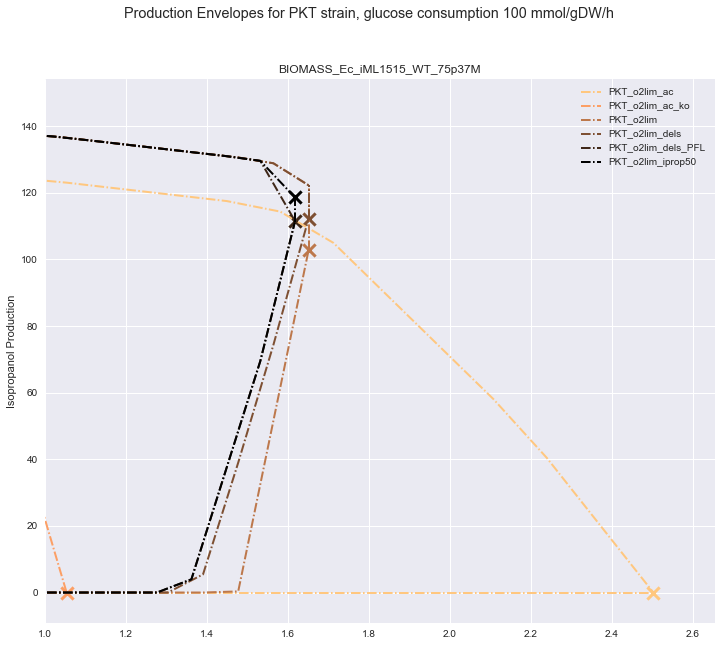

In [91]:
r = bmr
# model_ref = 'PKT'
"""
# Charge data from fermentation 1242
data_ferm_1242 = pd.read_excel(wd+'output/recap_ferm_data.xlsx', index_col=0)
row_ferm = {bmr:'bm', 'EX_co2_e':'co2', 'EX_o2_e':'o2'}
colors_1242 = {'MM':'navy', 'ZYM':'darkmagenta'}
markers = {'PKT':'x', 'Goret':'s', 'PKT_Lactis':'o'}

# Charge data from fermentation 515
data_ferm_515 = pd.read_excel(wd+'input/data/recap_ferm_515.xlsx', index_col=0)
color_515 = 'mediumturquoise'

# Charge data from fermentation 1117
data_ferm_1117 = pd.read_excel(wd+'input/data/recap_ferm_1117.xlsx', index_col=0)
color_1117 = 'lightcoral'
"""

fig = plt.figure(figsize=(12,10))
plt.suptitle('Production Envelopes for PKT strain, glucose consumption 100 mmol/gDW/h')
cols_env = list(cm.copper(np.linspace(0,1,len(scen))))

for s in scen:
    env = cameo.phenotypic_phase_plane(model[s], variables=r, objective='EX_2ppoh_e')
    s_col = cols_env.pop()
    x_max = max(env.data_frame[r])
    y_min = env.data_frame.objective_lower_bound.iloc[0]
    y_max = ymax=env.data_frame.objective_upper_bound.iloc[0]
    
    opt = react_data[s].loc[r]
    opt_env = min(env[r], key=lambda x:(np.fabs(x-opt)))
    idx_opt_env = list(env[env[r]==opt_env].index)[0]
    min_env = min(env[r], key=lambda x:(np.fabs(x-0)))
    idx_min_env = list(env[env[r]==min_env].index)[0]

    x_max = env.data_frame.loc[idx_opt_env,r]
    y_min = env.data_frame.objective_lower_bound[idx_opt_env]
    y_max = env.data_frame.objective_upper_bound[idx_opt_env]
    y_max_plot = env.data_frame.objective_upper_bound[idx_min_env]

    # Add surface
    X_ = np.linspace(1,x_max,40)
    Y_ = np.linspace(0,y_max_plot,40)
    X,Y = np.meshgrid(X_,Y_)
    Z = np.zeros(X.shape)
    #print(s, format(x_max,'.2f'), format(y_min,'.2f'), format(y_max,'.2f'))
    
    plt.plot(env.data_frame[r], env.data_frame.objective_lower_bound, color=s_col, ls='-.', lw=2, label=s)
    plt.plot(env.data_frame[r], env.data_frame.objective_upper_bound, color=s_col, ls='-.', lw=2, label='_nolegend_')
    plt.plot([x_max,x_max],[y_min,y_max], color=s_col, ls='-.', lw=2, label='_nolegend_')
    plt.title(r)
    
    # Add optimum pFBA
    opt_pFBA = [react_data[s].loc[bmr],react_data[s].loc['EX_2ppoh_e']]
    plt.scatter(opt_pFBA[0], opt_pFBA[1], color=s_col, marker='x', lw=3, s=150)
    
plt.ylabel('Isopropanol Production')
plt.xlim(xmin=1)

#plt.legend(bbox_to_anchor=(1.2, 0.8), fancybox=True)
plt.legend()
plt.show()

#fig.savefig('/Users/aalarcon/Desktop/prod_env_', bbox_inches='tight')

In [55]:
len(list(cm.copper(np.linspace(0,1,len(scen)))))

5

## Escher Visualisation

In [98]:
escher_out = True
scen_escher = 'PKT_o2lim_ac_ko'
map_json = None
map_json = wd+'files/maps/Map_EM_iprop_v3.json'

b = escher.Builder(map_json=map_json, model=model[scen[-1]], reaction_data=react_data[scen_escher].to_dict(), )

if escher_out:
    b.display_in_browser(never_ask_before_quit=True)


Note: You must interrupt the kernel to end this command

Serving to http://127.0.0.1:7655/
[Ctrl-C to exit from terminal, or Ctrl-M i i to interrupt notebook kernel]


127.0.0.1 - - [05/Dec/2017 14:31:05] "GET / HTTP/1.1" 200 -



stopping Server...


In [25]:
b.display_in_notebook(height=1000, js_source='local') 

In [ ]:
model['WT'].reactions.AKGDH

In [ ]:
"""
# Plot points fermentation
for strain in data_ferm_1242.columns:
    str_color = strain.split('_')[-1]
    str_marker = '_'.join(strain.split('_')[:-1])
    plt.scatter(data_ferm_1242.loc[row_ferm[r], strain], data_ferm_1242.loc['iprop', strain]+data_ferm_1242.loc['acetone', strain], label=strain, 
                color=colors_1242[str_color], marker=markers[str_marker])


# Ferm 515
for strain in ['PKT']:
    str_marker = strain
    plt.scatter(data_ferm_515.loc[row_ferm[r], strain], data_ferm_515.loc['acetone', strain], label=strain+'_515', 
                color=color_515, marker=markers[str_marker])
    
# Ferm 1117
for strain in ['PKT', 'Goret']:
    str_marker = strain
    plt.scatter(data_ferm_1117.loc[row_ferm[r], strain], data_ferm_1117.loc['acetone', strain], label=strain+'_1117', 
                color=color_1117, marker=markers[str_marker])

"""

KeyError: 'PKT_o2lim10_glu10'

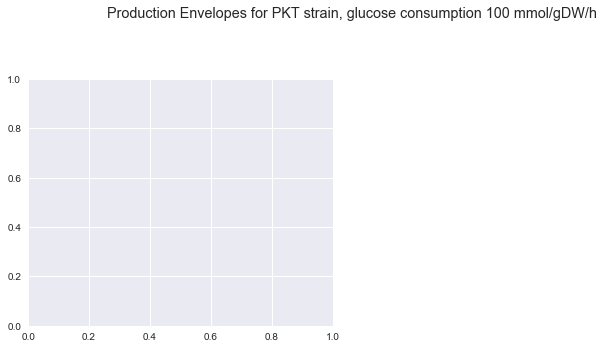

In [222]:
model_ref = 'PKT_o2lim10_glu10'

# Charge data from fermentation 1242
data_ferm_1242 = pd.read_excel(wd+'output/recap_ferm_data.xlsx', index_col=0)
row_ferm = {bmr:'bm', 'EX_co2_e':'co2', 'EX_o2_e':'o2'}
colors_1242 = {'MM':'navy', 'ZYM':'darkmagenta'}
markers = {'PKT':'x', 'Goret':'s', 'PKT_Lactis':'o'}

fig = plt.figure(figsize=(12,10))
plt.suptitle('Production Envelopes for PKT strain, glucose consumption 100 mmol/gDW/h')


for r,i in zip([bmr, 'EX_co2_e', 'EX_o2_e'], range(3)):
    plt.subplot(2,2,i+1)
    
    env = cameo.phenotypic_phase_plane(model[model_ref], variables=r, objective='EX_2ppoh_e')
    plt.plot(env.data_frame[r], env.data_frame.objective_lower_bound, color='k', ls='--', lw=1, label='_nolegend_')
    plt.plot(env.data_frame[r], env.data_frame.objective_upper_bound, color='k', ls='--', lw=1, label='_nolegend_')
    plt.title(r)
    plt.ylabel('Isopropanol Production')
    if r == 'EX_co2_e':
        plt.xlim(xmin=0)
    # Plot points fermentation
    for strain in data_ferm_1242.columns:
        str_color = strain.split('_')[-1]
        str_marker = '_'.join(strain.split('_')[:-1])
        plt.scatter(data_ferm_1242.loc[row_ferm[r], strain], data_ferm_1242.loc['iprop', strain]+data_ferm_1242.loc['acetone', strain], label=strain, 
                    color=colors_1242[str_color], marker=markers[str_marker])
    if i==2:
        plt.legend(bbox_to_anchor=(1.8, 0.8), fancybox=True, title='Legend Strains')
fig.savefig('/Users/aalarcon/Documents/Présentations/6_Réunion_dept/figures/prod_env_isoprop_acetone_1242.png')

### Linear MOMA

In [77]:
df_res = pd.DataFrame(index=scen_lmoma, columns=['gr', 'ex_glc', 'acetone', 'iprop'])

for s in scen_lmoma:
    res = lmoma(model[s], reference=react_data[ref_lmoma[s]])
    react_data[s] = res.fluxes
    res.data_frame.to_csv(wd+'output/react_data/lmoma_'+s+'.csv')
    print('OK for', s+'\t')
    df_res.loc[s] = [format(res.data_frame.loc[bmr, 'flux'],'.2f'), 
          format(res.data_frame.loc['EX_glc__D_e', 'flux'],'.0f'),
          format(res.data_frame.loc['EX_acetone_e', 'flux'],'.0f'),
          format(res.data_frame.loc['EX_2ppoh_e', 'flux'],'.0f')]

df_res

,gr,ex_glc,acetone,iprop
